<a href="https://colab.research.google.com/github/chechelan/0-chechelan/blob/main/Making_LEGO_Minifigures_with_Deep_Convolutional_Generative_Adversarial_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
How many minifigures there are in the world? Can we make a new minifigure with different faces, smiles, clothes, wigs or decorations? Yes, we have many random and purposed combinations, but how does machine learning solve this innovation? The research question is how to create realistic-looking LEGO Minifigures using a deep convolutional generative adversarial network.There are two models in DCGAN, descriminator and generator, the generator and discriminator are trained separately but in an adversarial manner. The practical relevance of is to develop a method for automatically generating LEGO.

## Dataset

* All LEGO minifigures are scraped from [https://www.bricklink.com/catalogTree.asp?itemType=M](https://), there are thoudsands of minifigures since the first one was launched in 1978, but high quality minifigure picrtures are rare. I scraped 4000+ images(scraping codes are in appendix) from bricklink and manually selected 2920 images with clear background, then played in photoshop to improve picture qualities, while they are still not so clear. Advantage of the dataset is all images are very formal and with clean background, the high quality dataset sets a solid foundation for the model. 

* Data file: 2920 images, .jpg format, 64*64pix, color channels RGB


In [1]:
#import libraries
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

import imageio 
import glob 

from IPython.display import display, Image

In [2]:
# processed data is a zipped file called lg.zip which is uploaded on google drive, so need mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [3]:
#unzip the file on google drive and save in created new folder xx
!unzip /content/gdrive/MyDrive/lg.zip -d xx

Archive:  /content/gdrive/MyDrive/lg.zip
replace xx/ps/i10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: xx/ps/i10.jpg           
  inflating: xx/ps/i111.jpg          
  inflating: xx/ps/i112.jpg          
  inflating: xx/ps/i113.jpg          
  inflating: xx/ps/i114.jpg          
  inflating: xx/ps/i115.jpg          
  inflating: xx/ps/i116.jpg          
  inflating: xx/ps/i118.jpg          
  inflating: xx/ps/i123.jpg          
  inflating: xx/ps/i124.jpg          
  inflating: xx/ps/i126.jpg          
  inflating: xx/ps/i127.jpg          
  inflating: xx/ps/i129.jpg          
  inflating: xx/ps/i13.jpg           
  inflating: xx/ps/i131.jpg          
  inflating: xx/ps/i133.jpg          
  inflating: xx/ps/i135.jpg          
  inflating: xx/ps/i14.jpg           
  inflating: xx/ps/i142.jpg          
  inflating: xx/ps/i143.jpg          
  inflating: xx/ps/i144.jpg          
  inflating: xx/ps/i145.jpg          
  inflating: xx/ps/i146.jpg          
  inflating: xx/ps/i14

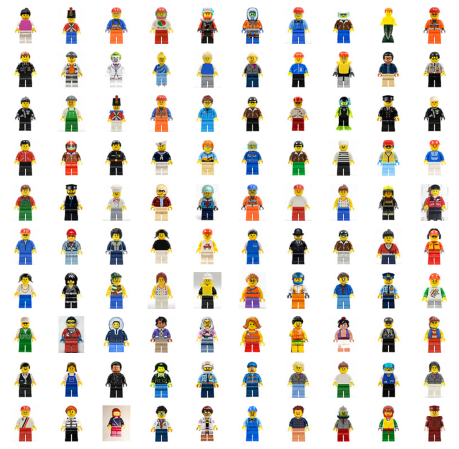

In [4]:
#Display real images in the folder 
folder = '/content/xx/ps'
images = os.listdir(folder)[:100]
fig = plt.figure(figsize=(8, 8))

for i, img in enumerate(images):
    path = os.path.join(folder, img)
    image = plt.imread(path)
    ax = fig.add_subplot(10, 10, i+1)
    plt.imshow(image,cmap='gray')
    plt.axis('off')

plt.show()

In [5]:
# create the dataset from directory to use in tensorflow 
dataset = keras.utils.image_dataset_from_directory("xx"
                                                   ,label_mode = None
                                                   ,color_mode = 'rgb'
                                                   ,batch_size = 32
                                                   ,image_size = (64,64) #height,width,the pipeline processes batches of images that must all have the same size                             
                                                   ,smart_resize=True
                                                   )

Found 2920 files belonging to 1 classes.


In [6]:
# Image processing, scaling the pixel values to the range [0, 1] 

dataset = dataset.map(lambda x:x/255)

## Generative model

#### Build a discriminator network (CNN-based image classifier)

In [7]:
discriminator = keras.Sequential(
    [
        #define the input shape 64*64*3
        keras.Input(shape=(64,64,3)),
        # upsampling 
        layers.Conv2D(filters = 64,
                      kernel_size = (4,4),
                      strides = (2,2),
                      padding='same'),
        # LeakyReLU activation layers are used to introduce non-linearity to the model
        layers.LeakyReLU(alpha=0.2),
        #upsampling 
        layers.Conv2D(filters = 128,
                      kernel_size = (4,4),
                      strides= (2,2),
                      padding='same'),
        layers.LeakyReLU(alpha=0.2),
        #upsampling 
        layers.Conv2D(filters = 128,
                      kernel_size = (4,4),
                      strides = (2,2),
                      padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        #use dropout to prevent overfitting
        layers.Dropout(0.2),
        #a dense layer with sigmoid activation function
        layers.Dense(1,activation = 'sigmoid'),
    ],
    name = 'discriminator',
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

#### Build a generator network

In [8]:
latent_dim = 128 #noise vector

generator = keras.Sequential(
    [
        #Dense layer that maps the input noise vector to a tensor of shape 8*8*128
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8*8*128),
        layers.Reshape((8,8,128)),
        #upsampling 16*16*128
        layers.Conv2DTranspose(filters = 128,
                               kernel_size = (4,4), 
                               strides = (2,2), 
                               padding='same'),
        layers.LeakyReLU(alpha=0.2),
        #upsampling 32*32*256
        layers.Conv2DTranspose(filters = 256,
                               kernel_size = (4,4), 
                               strides = (2,2), 
                               padding='same'),
        layers.LeakyReLU(alpha=0.2),
        #upsampling 64*64*512
        layers.Conv2DTranspose(filters = 512,
                               kernel_size = (4,4), 
                               strides = (2,2), 
                               padding='same'),
        layers.LeakyReLU(alpha=0.2),
        #output layer  64*64*3
        layers.Conv2D(filters = 3, 
                      kernel_size = (5,5), 
                      padding='same',
                      activation='sigmoid'),            
    ],
    name='generator'
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

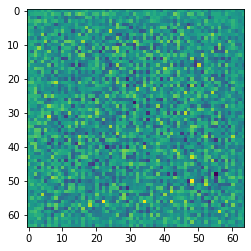

In [9]:
#try untrained generator model with noise, create a random noise/latent_dim
noise = tf.random.normal([1,128])
generated_image = generator(noise, training=False)
# generate the image
plt.imshow(generated_image[0, :, :, 0])

#### Build the GAN model

In [10]:
#code source:come from the textbook deep learning with python, page 408-409, see in references
class GAN(keras.Model):
    #descriminator and generator loss 
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        #decode them to fake images/combine with real images 
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        #train the descriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        #train the generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

#### Generate and save images during training

In [11]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            #Use os.path.join to construct the full path to the image file
            folder_path = '/content/gdrive/MyDrive/trained_img'
            file_path = os.path.join(folder_path,f"generated_img_{epoch:03d}_{i}.png")
            img.save(file_path)
            


#### Compling and training the model

In [12]:
# Save the model every 50 epoch
checkpoint = ModelCheckpoint("/content/model.h5", save_weights_only=True, save_freq=50)

In [13]:
epochs = 500

gan = GAN( discriminator=discriminator, generator=generator, 
          latent_dim= latent_dim)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)


# Fit the GAN model and save the history
history = gan.fit(dataset, 
                  epochs=epochs, 
                  callbacks=[GANMonitor(num_img = 10, latent_dim=latent_dim),checkpoint]
                  )

Epoch 1/500
92/92 [==============================] - 5s 33ms/step - d_loss: 0.3528 - g_loss: 1.0952
Epoch 2/500
92/92 [==============================] - 3s 30ms/step - d_loss: 0.0037 - g_loss: 6.6950
Epoch 3/500
92/92 [==============================] - 3s 29ms/step - d_loss: 0.0398 - g_loss: 12.9773
Epoch 4/500
92/92 [==============================] - 3s 31ms/step - d_loss: 0.0062 - g_loss: 14.3960
Epoch 5/500
92/92 [==============================] - 3s 29ms/step - d_loss: 0.1527 - g_loss: 5.9441
Epoch 6/500
92/92 [==============================] - 3s 30ms/step - d_loss: 0.1179 - g_loss: 4.3800
Epoch 7/500
92/92 [==============================] - 3s 28ms/step - d_loss: 0.2869 - g_loss: 3.4205
Epoch 8/500
92/92 [==============================] - 3s 29ms/step - d_loss: 0.2649 - g_loss: 2.7432
Epoch 9/500
92/92 [==============================] - 3s 29ms/step - d_loss: 0.2625 - g_loss: 2.7967
Epoch 10/500
92/92 [==============================] - 3s 29ms/step - d_loss: 0.1819 - g_loss: 3.22

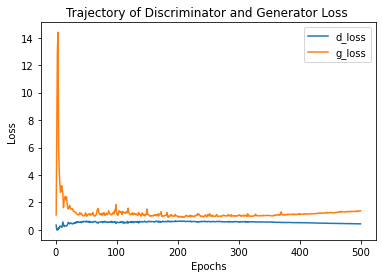

In [14]:
# Save the d_loss and g_loss in history object
d_loss = history.history['d_loss']
g_loss = history.history['g_loss']

# Plot the d_loss and g_loss
plt.plot(range(1, len(d_loss) + 1), d_loss, label='d_loss')
plt.plot(range(1, len(g_loss) + 1), g_loss, label='g_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Trajectory of Discriminator and Generator Loss ")
plt.legend()
plt.show()

- d_loss measures how well the discriminator is able to distinguish between real and fake images, which is calculated by comparing the output of the discriminator for real images and fake images. g_loss measures how well the generator is able to produce images that are similar to real images. The g_loss is calculated by comparing the output of the discriminator for the fake images generated by the generator.
- after 300 epochs, i can see the d_loss is declining slightly, but the trend is going down, and the g_loss shows slightly upoward trend, which is very positive, it indicates the generater works better and better.

## Evaluation

DCGAN is difficult to be evaluated in a quantified way, instead it is often evaluted in a qualified way, here I display the generated images from the model to show the results. First we can see it generated from noise to not stable minifigure shapes (0-50 epoch), which is great progress. From 50-150 epochs the model was still struggling, the minifigures shape seems improving. From epoch 200 some minifigures show the different faces, which means the model is learning more details. From epochs 400 I can clearly see some faces and find very nice images. So I think it works well with more epochs (one assumption from the poster) 

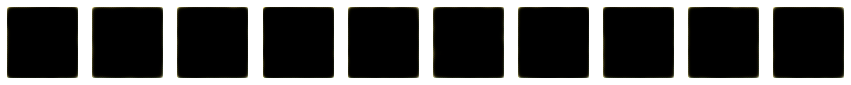

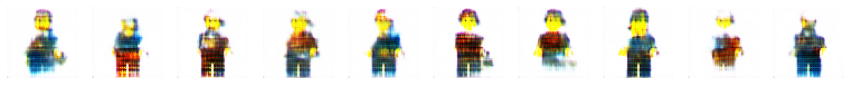

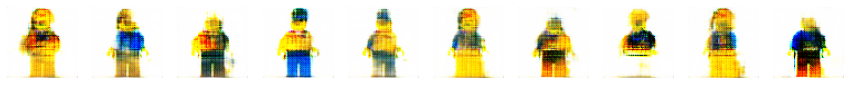

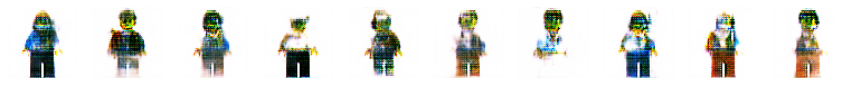

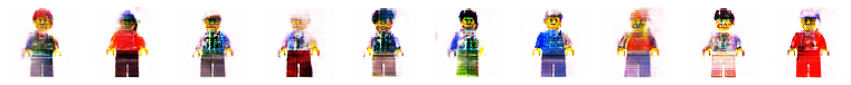

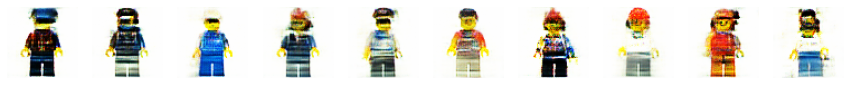

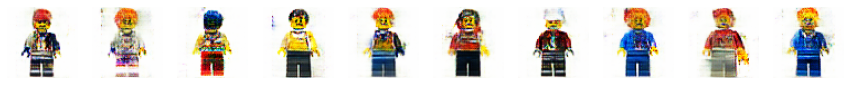

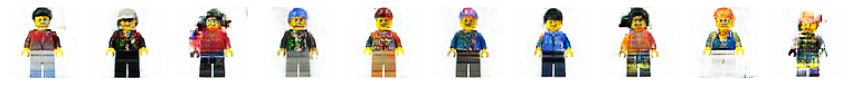

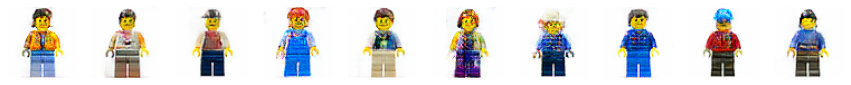

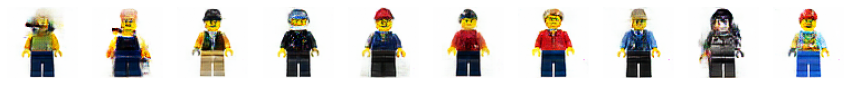

In [15]:
num_epochs = 500
num_images = 10

folder_path = '/content/gdrive/MyDrive/trained_img'
for epoch in range(num_epochs):
    if epoch % 50 == 0: #display images every 50 epochs
        fig,axs = plt.subplots(1, num_images, figsize=(15,15))
        for i in range(num_images):
            file_path = os.path.join(folder_path,f"generated_img_{epoch:03d}_{i}.png")
            img = plt.imread(file_path)
            axs[i].imshow(img)
            axs[i].axis('off')
        plt.show()

## Conclusion

- The model start from a (128, ) noise vector input, this loss graph showed the generator and discriminator loss trend in 300 training loops, it consumes a lot google colab GPU, while the results remain unsatisfying.
- While we can see the advanced side from the model is that: it shows the shape of minifigures well, all the small parts are in the right place. And it shows good color combination for the minifigures clothes. Especially from epoch 400 I see very good minifigures, eyes and face are clear, which shows the model learned the detailed features.  

## References 

[1] Chollet François. (2021). Deep learning with python (Second). Manning Publications. Retrieved January 20, 2023, from INSERT-MISSING-URL.

[2] Deep Convolutional Generative Adversarial Network | TensorFlow Core. (n.d.). TensorFlow. Retrieved December 14, 2021, from https://www.tensorflow.org/tutorials/generative/dcgan

[3] Nikhil Tomar. (2020) DCGAN — Implementing Deep Convolutional Generative Adversarial Network in TensorFlow — Idiot Developer from https://medium.com/analytics-vidhya/dcgan-implementing-deep-convolutional-generative-adversarial-network-in-tensorflow-idiot-41b2ddf9eddb

## Appendix

##### Data scraping code for brinklink data, which was implemented on spyder


```

import requests
def get_pictures(url,path):
    headers={
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.25 Safari/537.36 Core/1.70.3861.400 QQBrowser/10.7.4313.400'}
    re=requests.get(url,headers=headers)
    print(re.status_code)#check the status, 200 is normal
    with open(path, 'wb') as f:#save file to local drive
                for chunk in re.iter_content(chunk_size=128):
                    f.write(chunk)
def get_pictures_urls(text):
    st= "SRC='"
    m=len(st)
    i=0
    n=len(text)
    urls=[]#list to save url
    while i<n:
        if text[i:i+m]==st:
            url=''
            for j in range(i+m,n):
                if text[j]== "'":
                    i=j
                    urls.append(url)
                    break
                url+=text[j]
        i+=1
    return urls

headers={
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.25 Safari/537.36 Core/1.70.3861.400 QQBrowser/10.7.4313.400'}
url='https://www.bricklink.com/catalogList.asp?pg=3&catString=850&catType=M'
re=requests.get(url,headers=headers)
urls=get_pictures_urls(re.text)#to get all image urls on the page
for i in range(len(urls)):#scrap images
    url=urls[i]
    path='j3'+str(i)+'.png'
    get_pictures(url,path)

```

